## Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
import xarray as xr
from datetime import datetime
import pandas as pd
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from scipy import signal

import xskillscore as xs

## Load Data

In [2]:
O2min_humboldt = xr.open_dataarray('Humboldt_O2min_regridded.nc')
mw_humboldt = xr.open_dataarray('mw_hum_regridded.nc')

## Some Useful Functions

In [3]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

## Loading Datasets

In [4]:
mw_humboldt = weighted_temporal_mean(mw_humboldt)
O2min_humboldt = weighted_temporal_mean(O2min_humboldt)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(
/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xarray/groupers.py:487: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  self.index_grouper = pd.Grouper(


## Correlation Map

In [5]:
O2min_detrended = xr.apply_ufunc(signal.detrend, O2min_humboldt.fillna(0).transpose('lat', 'lon', 'time'))
mw_detrended = xr.apply_ufunc(signal.detrend, mw_humboldt.fillna(0).transpose('lat', 'lon', 'time'))

O2min_detrended = O2min_detrended.where(O2min_detrended!=0)
mw_detrended = mw_detrended.where(mw_detrended!=0)

In [6]:
humboldt_correlation = xr.Dataset()
humboldt_correlation['coeff'] = xs.pearson_r(O2min_detrended, mw_detrended, dim='time')
humboldt_correlation['p_value'] = xs.pearson_r_eff_p_value(O2min_detrended, mw_detrended, dim='time')

In [7]:
# Get coordinates where statistically significant
indices = np.argwhere(humboldt_correlation.p_value.values<0.05)
x = humboldt_correlation.lon[indices[:,1]]
y = humboldt_correlation.lat[indices[:,0]]

In [9]:
uvel_humboldt = xr.open_dataarray('uvel_humboldt_regridded.nc')
vvel_humboldt = xr.open_dataarray('vvel_humboldt_regridded.nc')

In [10]:
uvel_humboldt_spatial = uvel_humboldt.mean('time').sel(z_t=slice(0,500)).mean('z_t')
vvel_humboldt_spatial = vvel_humboldt.mean('time').sel(z_t=slice(0,500)).mean('z_t')

In [11]:
u = uvel_humboldt_spatial.values
v = vvel_humboldt_spatial.values

In [12]:
X, Y = np.meshgrid(uvel_humboldt_spatial.lon, uvel_humboldt_spatial.lat)

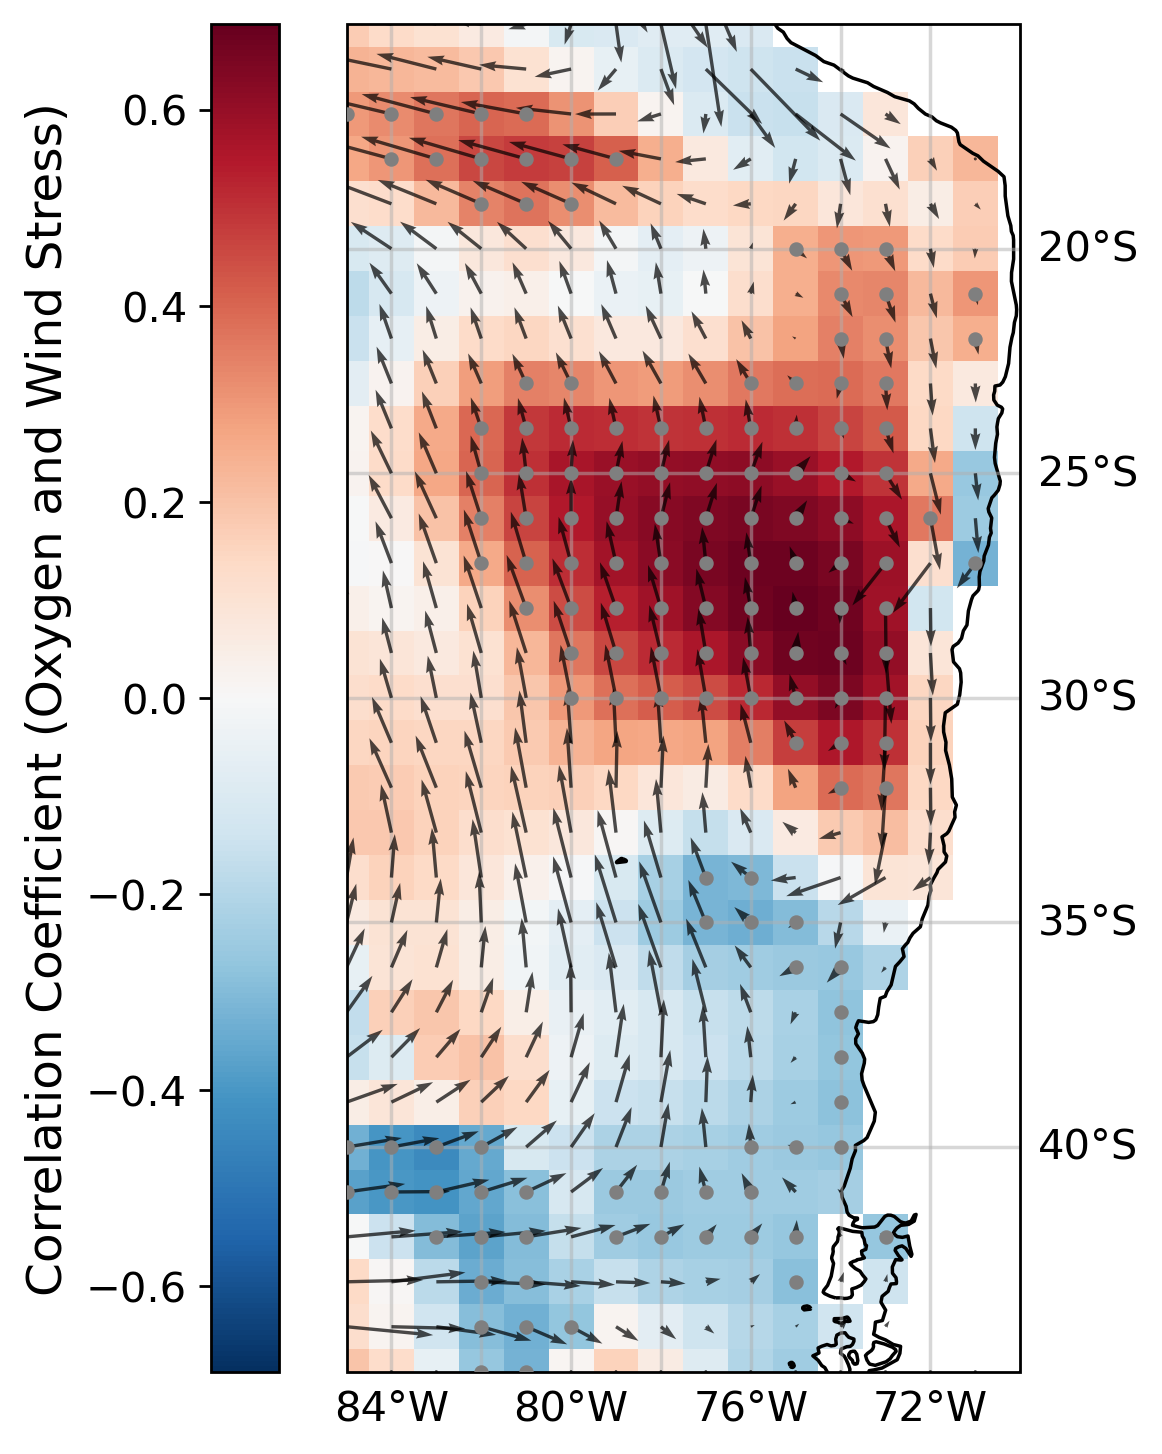

In [13]:
fig = plt.figure(figsize=(7, 7), dpi=250)
ax = plt.axes(projection=ccrs.PlateCarree())
pc = humboldt_correlation.coeff.plot.pcolormesh(ax=ax, x="lon", y="lat", 
                                                cbar_kwargs={'location':'left', 'pad':0.05})
pc.colorbar.ax.set_ylabel('Correlation Coefficient (Oxygen and Wind Stress)', fontsize=14)
pc.colorbar.ax.tick_params(labelsize=12)
ax.scatter(x, y, c='tab:gray', s=10, zorder=10, alpha=1)
ax.coastlines()
ax.set_extent([275, 290, -15, -45])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=.5, linewidth=1)
gl.top_labels = False
gl.left_labels = False
gl.xlabel_style = {'size':12}
gl.ylabel_style = {'size':12}

ax.quiver(X,Y,u,v, scale=0.15, width=0.005, alpha=0.7, zorder=9)

fig.patch.set_fill(False)
plt.show()

## Advection Timeseries

In [14]:
vvel_humboldt_southward = vvel_humboldt.where(vvel_humboldt.mean('time').sel(z_t=slice(100,400)).mean('z_t')<0).sel(lat=slice(-40,-15))

In [15]:
vvel_humboldt_southward = vvel_humboldt_southward.sel(z_t=slice(100,400), lon=slice(277,290))

vvel_NE_timeseries = vvel_humboldt_southward.mean(dim=('lat','lon','z_t'))
vvel_NE_timeseries = vvel_NE_timeseries.groupby('time.year').mean('time')

In [16]:
O2min_humboldtN = O2min_humboldt.sel(lat=slice(-33,-15))
O2min_humboldt_timeseries = O2min_humboldtN.groupby('time.year').mean('time').mean(dim=('lat','lon'))

In [17]:
vvel_NE_detrended = xr.apply_ufunc(signal.detrend, vvel_NE_timeseries)
O2min_humboldtN_detrended = xr.apply_ufunc(signal.detrend, O2min_humboldt_timeseries)

In [18]:
xs.pearson_r(vvel_NE_detrended.rolling(year=4, center=True).mean()[5:], O2min_humboldtN_detrended[5:], skipna=True)

<xarray.DataArray ()> Size: 8B
array(-0.67493747)

In [19]:
xs.pearson_r_eff_p_value(vvel_NE_detrended.rolling(year=4, center=True).mean()[5:], O2min_humboldtN_detrended[5:], skipna=True)

/Users/aschefler/opt/anaconda3/envs/OMZ_paper_env/lib/python3.12/site-packages/xskillscore/core/deterministic.py:485: UserWarning: ['year'] is not 'time'. Make sure that you are applying this over a temporal dimension.
  warnings.warn(


<xarray.DataArray ()> Size: 8B
array(0.04608673)

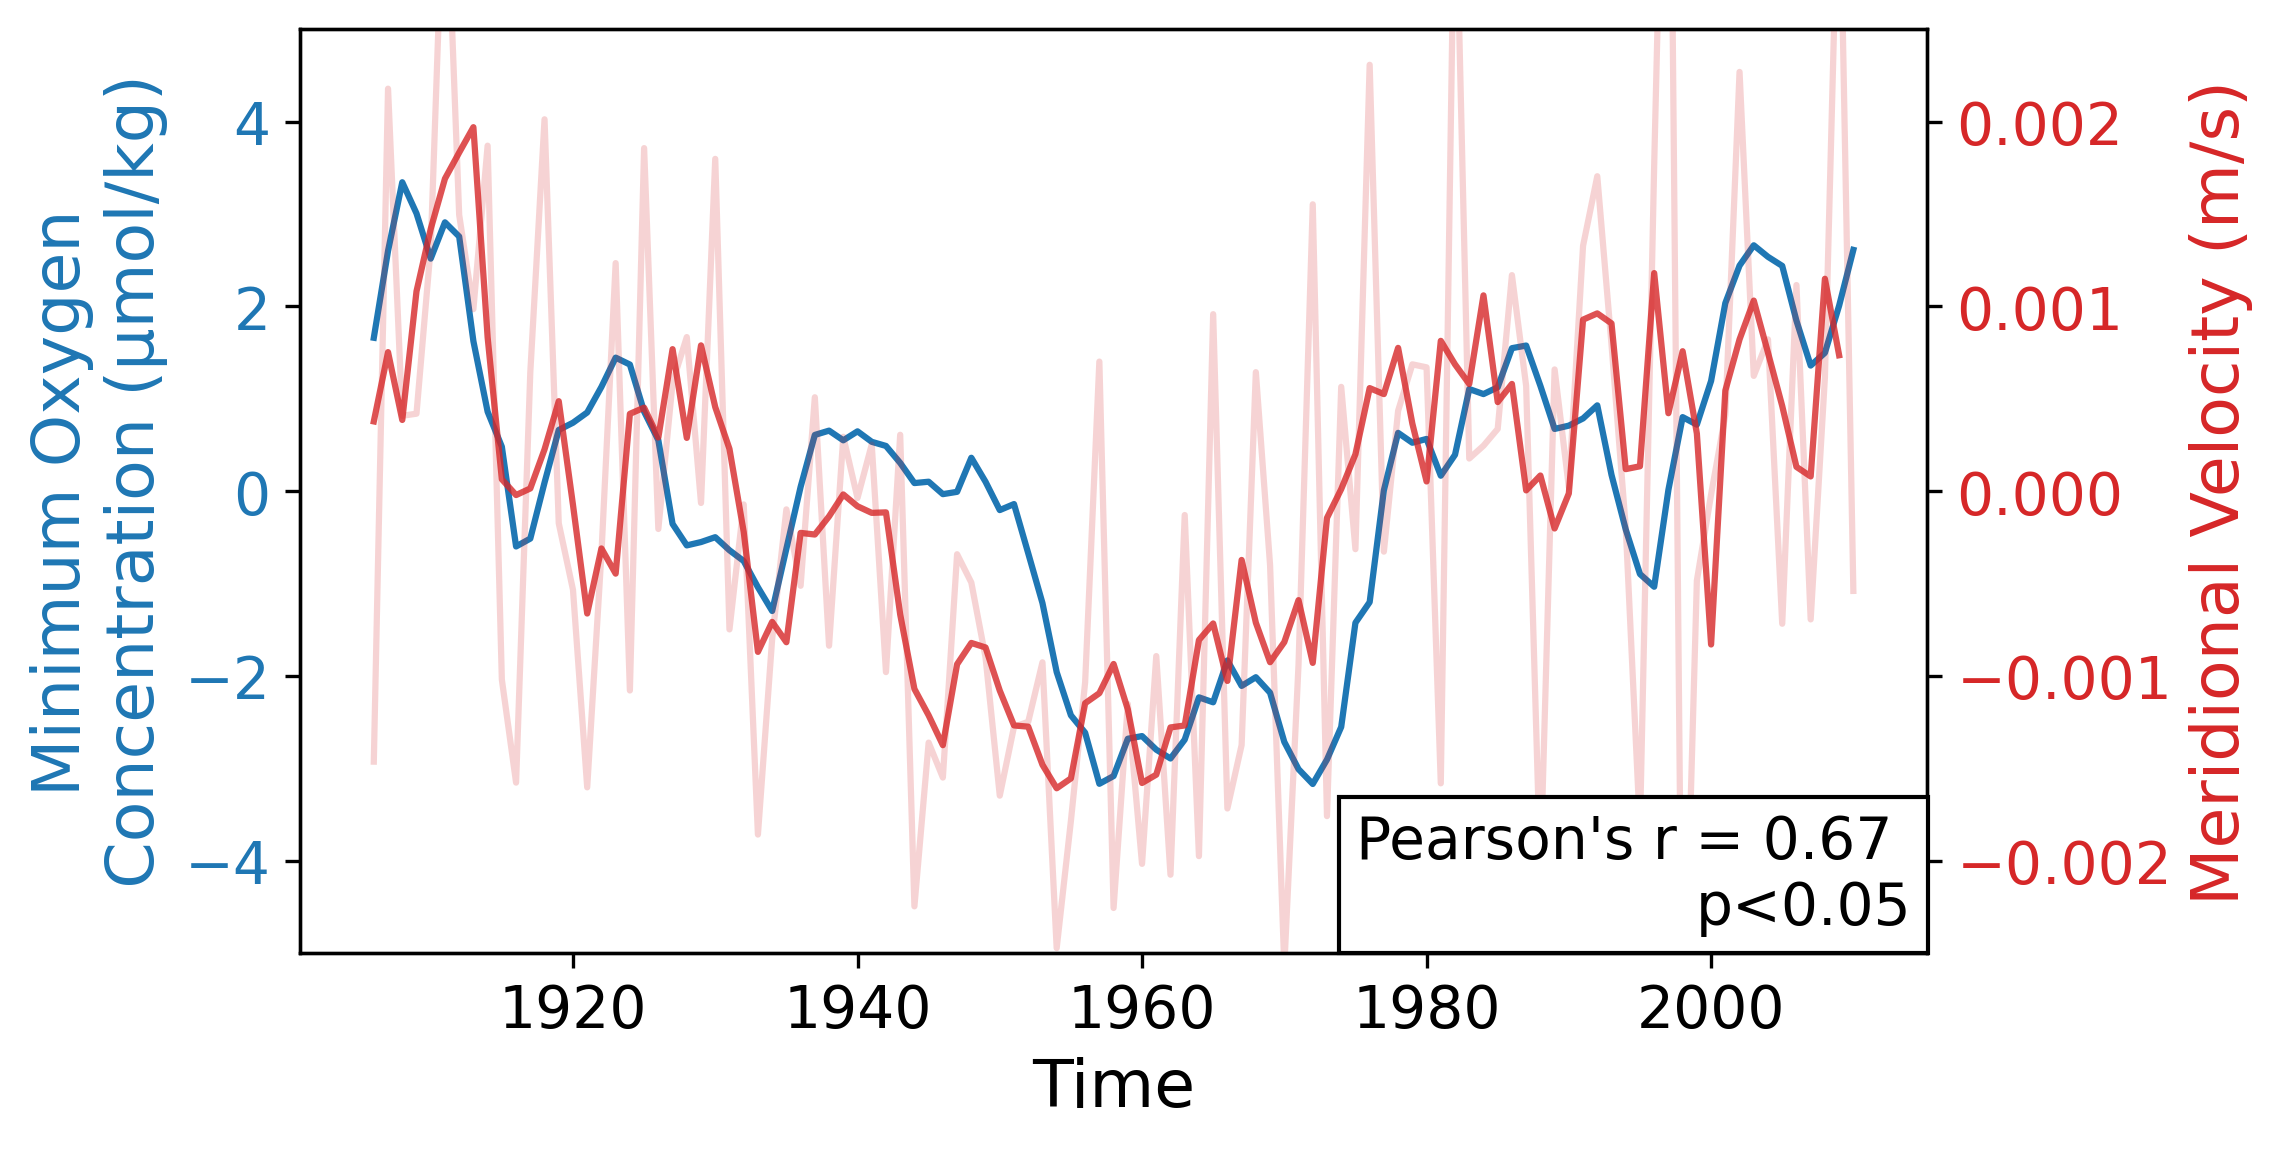

In [20]:
fig, ax = plt.subplots(figsize=(7,4), dpi=300)

ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax.set_ylabel('Minimum Oxygen \n Concentration (µmol/kg)', color='tab:blue', fontsize=16)
ax.plot(O2min_humboldtN_detrended.year[5:], O2min_humboldtN_detrended[5:], color='tab:blue')
ax.set_ylim([-5, 5])
ax.set_xlabel('Time', fontsize=16)
ax.tick_params(axis='x', labelsize=14)

ax2 = ax.twinx()
ax2.plot(vvel_NE_detrended.year[5:], -vvel_NE_detrended.rolling(year=4, center=True).mean()[5:], color='tab:red', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel('Meridional Velocity (m/s)', color='tab:red', fontsize=16)
ax2.set_ylim([-0.0025, 0.0025])

ax2.plot(vvel_NE_detrended.year[5:], -vvel_NE_detrended[5:], color='tab:red', alpha=0.2)

ax2.text(x=0.99, y=0.031, s='Pearson\'s r = 0.67 \np<0.05' , transform=ax.transAxes, fontsize=14, 
        horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', zorder=10))

fig.patch.set_fill(False)
plt.show()

## Biological Productivity Timeseries

In [23]:
DOC_remin = xr.open_dataarray('DOC_remin_hum_regridded.nc')
DOC_remin = DOC_remin.where(DOC_remin.lon<290)

In [24]:
DOC_remin_alldepths = DOC_remin.sum('z_t').where(DOC_remin.sum('z_t') > 0)

In [27]:
DOC_remin_N = DOC_remin_alldepths.sel(lat=slice(-33, -15))
DOC_remin_S = DOC_remin_alldepths.sel(lat=slice(-45, -33))

DOC_remin_N_ts = DOC_remin_N.mean(dim=('lat','lon')).groupby('time.year').mean('time')
DOC_remin_S_ts = DOC_remin_S.mean(dim=('lat','lon')).groupby('time.year').mean('time')

In [28]:
O2min_N = O2min_humboldt.sel(lat=slice(-33, -15))
O2min_S = O2min_humboldt.sel(lat=slice(-45, -33))

In [29]:
O2min_N_ts = O2min_N.mean(dim=('lat','lon')).groupby('time.year').mean('time')
O2min_S_ts = O2min_S.mean(dim=('lat','lon')).groupby('time.year').mean('time')

In [30]:
O2min_S_detrended = xr.apply_ufunc(signal.detrend, O2min_S_ts)
O2min_N_detrended = xr.apply_ufunc(signal.detrend, O2min_N_ts)

DOC_remin_S_detrended = xr.apply_ufunc(signal.detrend, DOC_remin_S_ts)
DOC_remin_N_detrended = xr.apply_ufunc(signal.detrend, DOC_remin_N_ts)

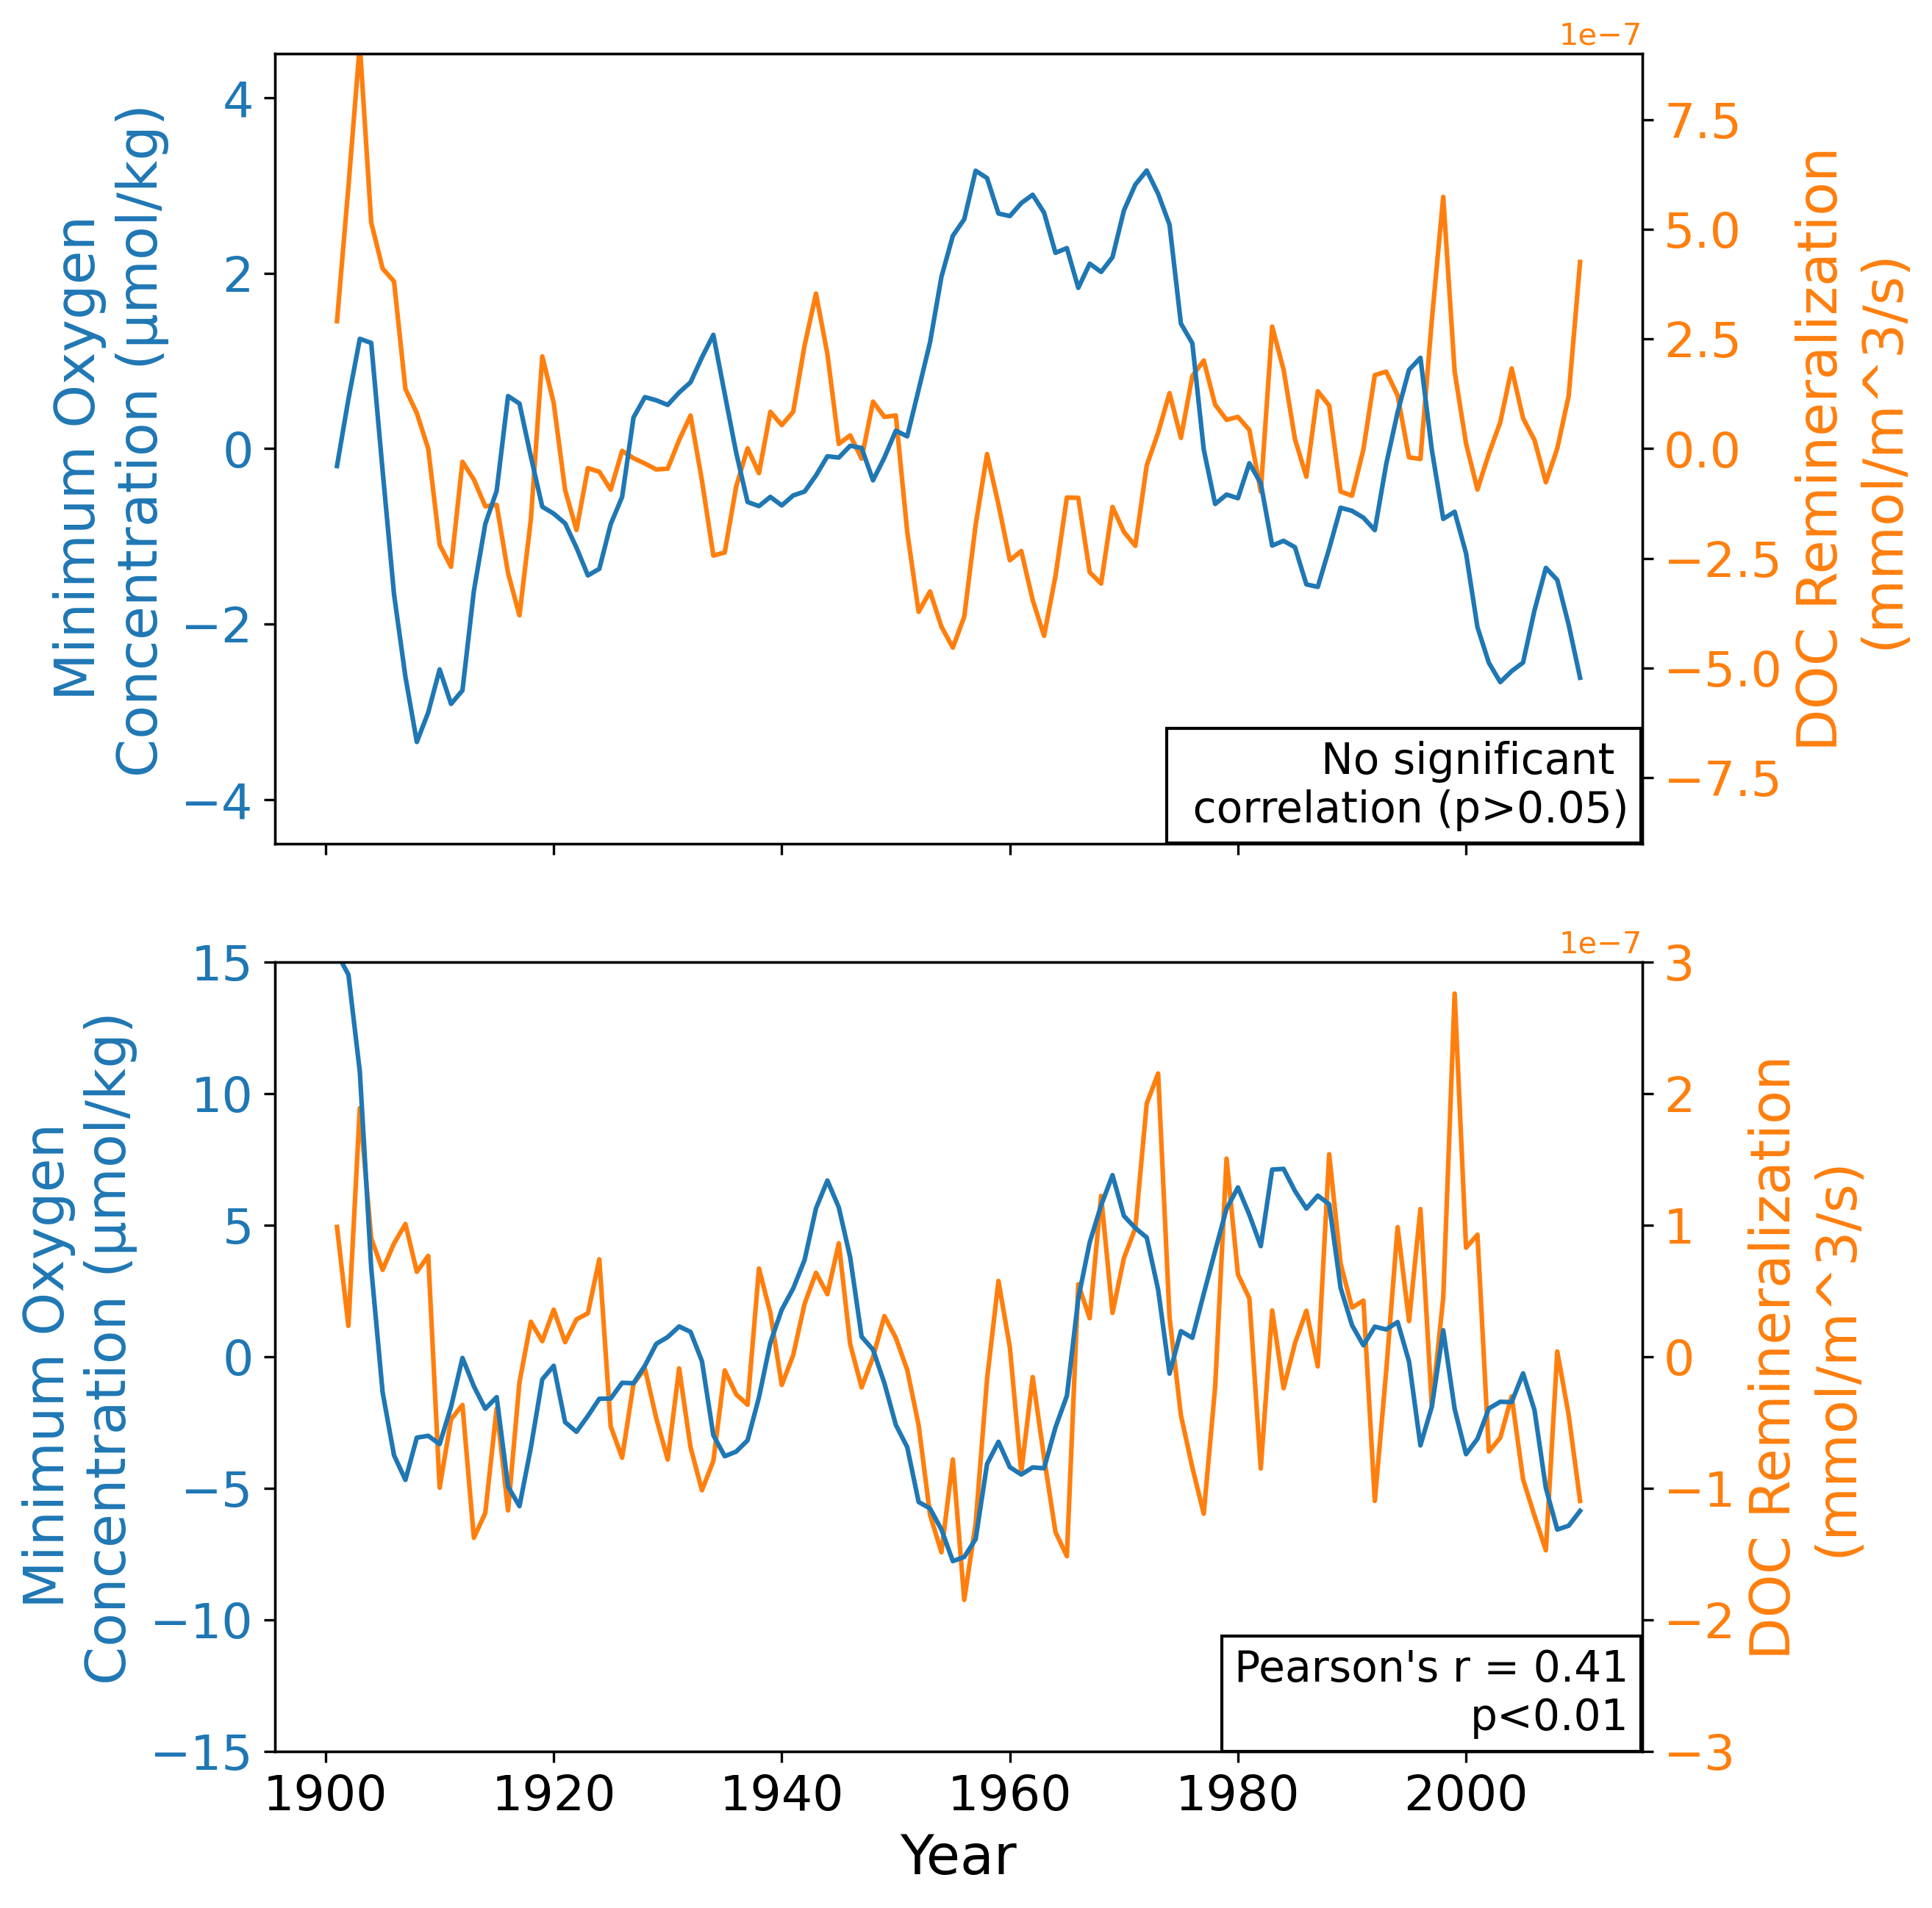

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(8,10), sharex=True, dpi=300)

ax[0].plot(O2min_N_detrended.year, -O2min_N_detrended)
ax[0].tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
ax[0].set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=18)
ax[0].set_ylim([-4.5,4.5])

ax2 = ax[0].twinx()
ax2.plot(DOC_remin_N_detrended.year, DOC_remin_N_detrended, color='tab:orange')
ax[0].patch.set_visible(False)
ax[0].set_zorder(ax2.get_zorder()+1)
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)
ax2.set_ylabel('DOC Remineralization\n(mmol/m^3/s)', color='tab:orange', fontsize=18)
ax2.set_ylim([-9e-7,9e-7])

ax2.text(x=0.99, y=0.027, s='No significant \n correlation (p>0.05)' , transform=ax2.transAxes, fontsize=14, 
        horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', zorder=10))

ax[1].plot(O2min_S_detrended.year, -O2min_S_detrended)
ax[1].tick_params(axis='y', labelcolor='tab:blue', labelsize=16)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=18)
ax[1].set_xlabel('Year', fontsize=18)
ax[1].set_ylim([-15,15])

ax2 = ax[1].twinx()
ax2.plot(DOC_remin_S_detrended.year, DOC_remin_S_detrended, color='tab:orange')
ax[1].patch.set_visible(False)
ax[1].set_zorder(ax2.get_zorder()+1)
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=16)
ax2.set_ylabel('DOC Remineralization\n(mmol/m^3/s)', color='tab:orange', fontsize=18)
ax2.set_ylim([-3e-7,3e-7])

ax2.text(x=0.99, y=0.027, s='Pearson\'s r = 0.41\np<0.01' , transform=ax2.transAxes, fontsize=14, 
        horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', zorder=10))

plt.subplots_adjust(hspace=0.15)

plt.show()

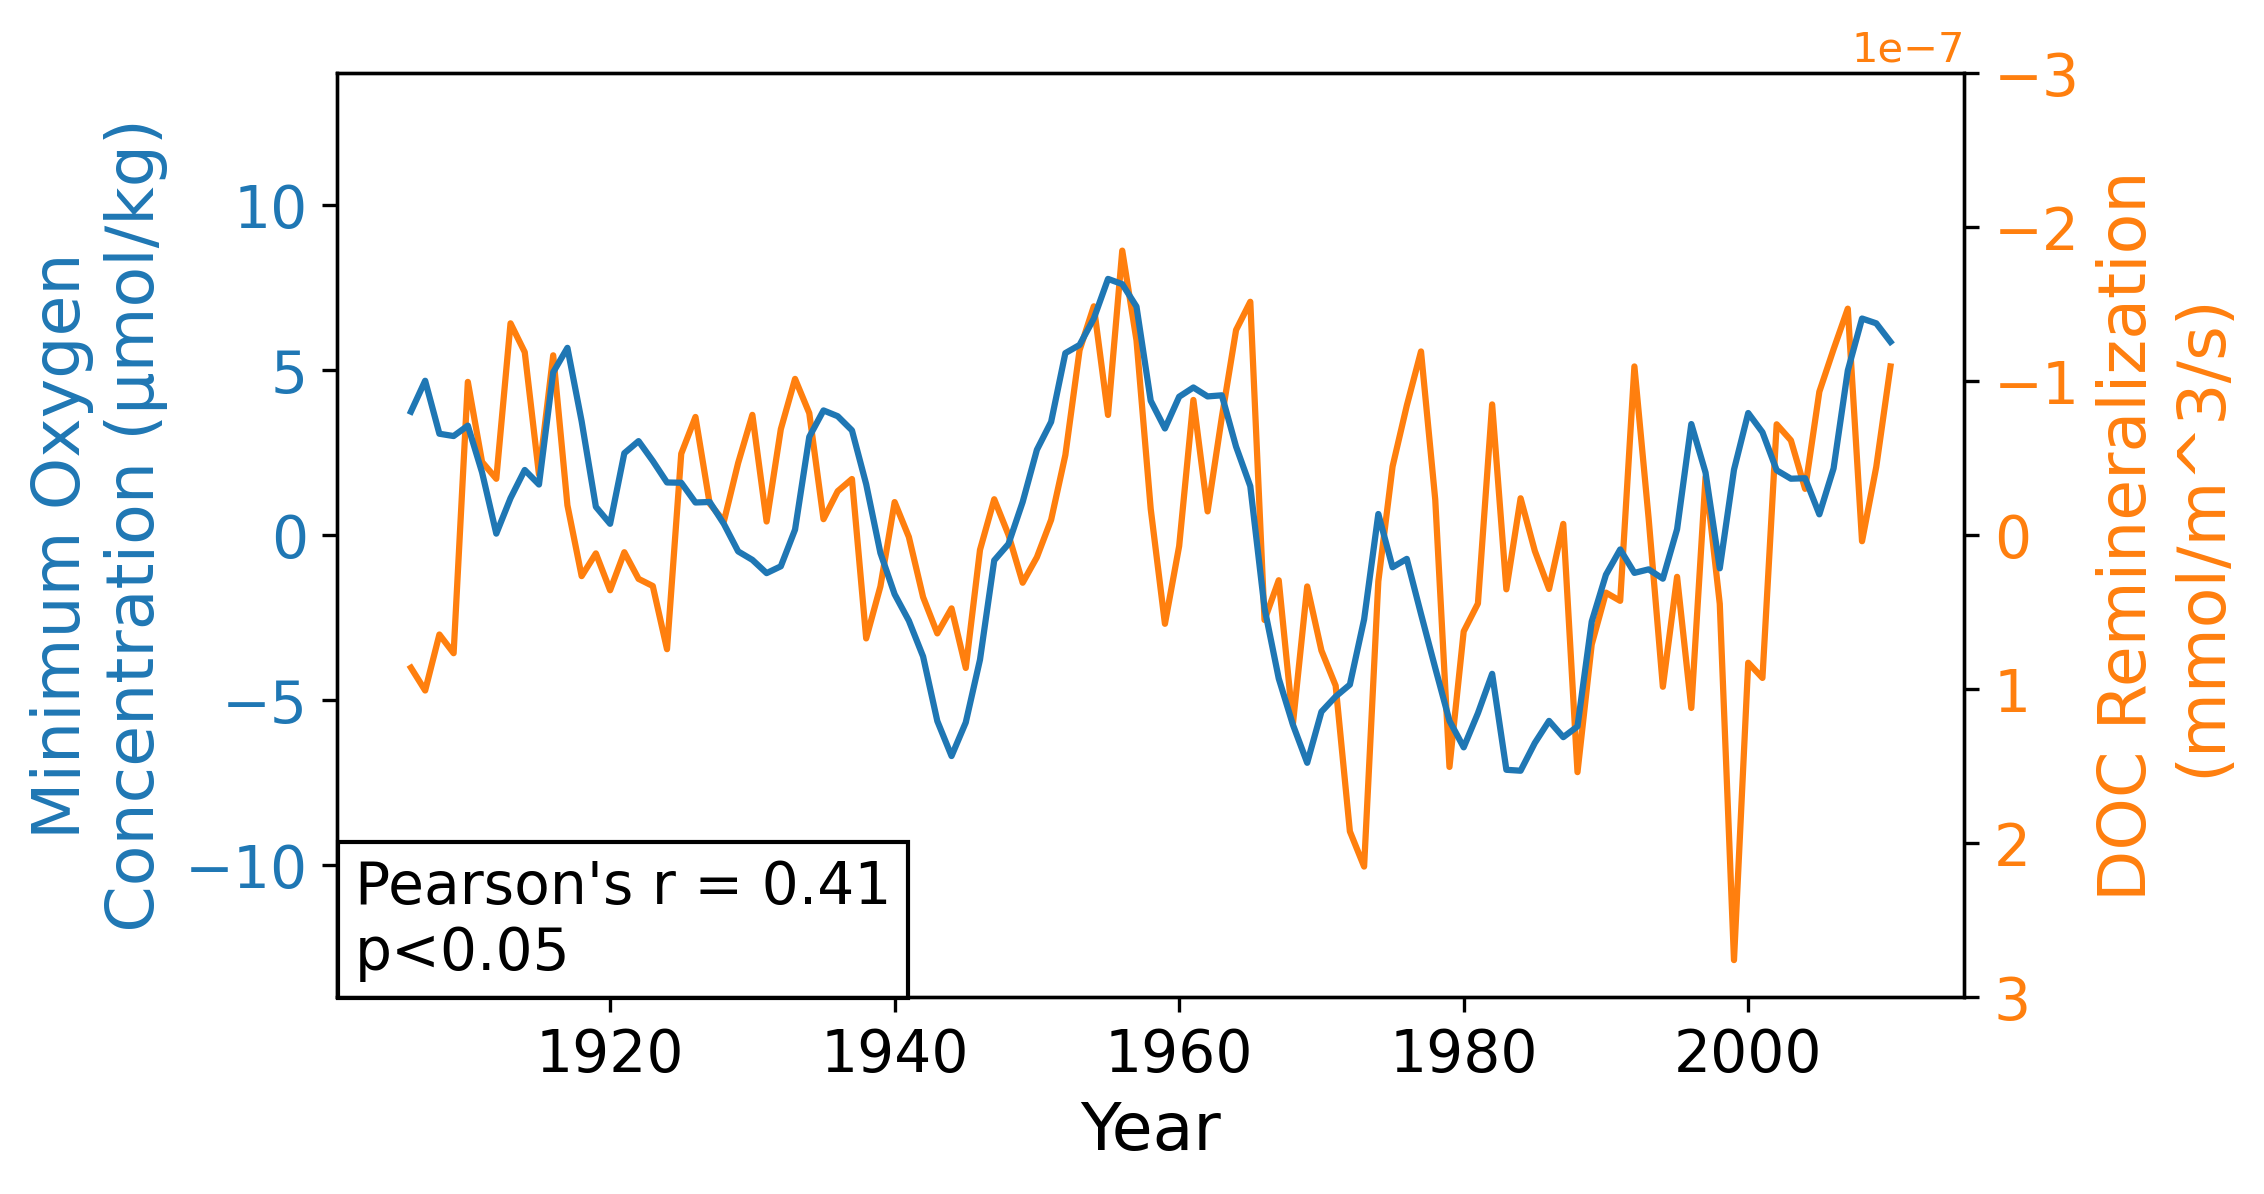

In [32]:
fig, ax = plt.subplots(figsize=(7,4), dpi=300)

ax.plot(O2min_S_detrended.year[5:], O2min_S_detrended[5:])
ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylabel('Minimum Oxygen \n Concentration (μmol/kg)', color='tab:blue', fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylim([-14,14])

ax2 = ax.twinx()
ax2.plot(DOC_remin_S_detrended.year[5:], DOC_remin_S_detrended[5:], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=14)
ax2.set_ylabel('DOC Remineralization\n(mmol/m^3/s)', color='tab:orange', fontsize=16)
ax2.set_ylim([-3e-7,3e-7])
ax2.invert_yaxis()

ax2.text(x=0.011, y=0.03, s='Pearson\'s r = 0.41\np<0.05' , transform=ax2.transAxes, fontsize=14, 
        horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='black', zorder=10))

ax.patch.set_visible(False)
ax.set_zorder(10)

plt.show()